# <p style="background-color:#1c56c9; font-family:newtimeroman; font-size:150%; text-align:center; border-radius:  25px; color:#ffffff; padding-top:5px; padding-bottom:5px;">Forecasting the Stock Market with LSTM</p>

# Stock Market

<img src="https://blog.clear.com.br/wp-content/uploads/2018/12/margem-de-garantia-trader.png">

The stock market is a public and organized environment for trading certain securities and real estate (stocks, stock options, real estate funds, etc.). Transactions can take place through stock exchanges or on the so-called over-the-counter markets (markets in which securities not traded on exchanges are traded, within the legal rules provided for by law and regulations, without coordination by private self-regulatory entities).

# Understanding the Problem

In the stock market, we carry out purchase and sale transactions for profit. In this example, we are going to analyze the LSTM neural network to predict the stock's closing price in 10 days. It's just one example of the power of neural networks.

## What is Long Short Term Memory (LSTM)
LSTM is a recurrent neural network (RNN) architecture that “remembers” values ​​at arbitrary intervals. LSTM is well suited for classifying, processing and predicting time series with time intervals of unknown duration. We can apply for price prediction, sentiment analysis, text generation.

The network has 3 gates:
* Forget Gate: Information that is no longer useful in cell state is removed with forget gate. Two inputs: x_t (point-in-time input) and h_t-1 (previous cell output) are fed to the gate and multiplied by weight matrices, followed by the addition of the bias. The resultant is passed through an activation function that provides a binary output. If for a given cell state the output is 0, the information is forgotten and for output 1, the information is retained for future use.


* Input Gate: Adding useful information to the cell state is done by the input gate. First, the information is regulated using the sigmoid function which filters the values ​​to be remembered similarly to forget gate using the h_t-1 and x_t inputs. Then, a vector is created using the tanh function that outputs -1 to +1, which contains all possible values ​​of h_t-1 and x_t. Vector values ​​and calibrated values ​​are multiplied to obtain useful information.


* Output Gate: The task of extracting useful information from the current cell state to be presented as an output is done by the output gate. First, a vector is generated by applying the tanh function to the cell. Then, the information is regulated using the sigmoid function that filters the values ​​to be remembered using the inputs h_t-1 and x_t. Vector values ​​and regulated values ​​are multiplied to be sent as an output and input to the next cell. 

<img src="https://www.deeplearningbook.com.br/wp-content/uploads/2019/08/lstmcell.png">

* <a href="#import">Import</a>

* <a href="#eda">EDA</a>

* <a href="#functions">Functions</a>

* <a href="#model">Model</a>

* <a href="#predictions">Predictions</a>

<a name="import">

# <p style="background-color:#1c56c9; font-family:newtimeroman; font-size:150%; text-align:center; border-radius:  25px; color:#ffffff; padding-top:5px; padding-bottom:5px;">Import</p>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('MSFT.csv',
                 infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2017-01-03,62.790001,62.840000,62.130001,62.580002,57.807823,20694100
2017-01-04,62.480000,62.750000,62.119999,62.299999,57.549179,21340000
2017-01-05,62.189999,62.660000,62.029999,62.299999,57.549179,24876000
2017-01-06,62.299999,63.150002,62.040001,62.840000,58.047993,19922900
2017-01-09,62.759998,63.080002,62.540001,62.639999,57.863243,20382700


<a name="eda">
    
# <p style="background-color:#1c56c9; font-family:newtimeroman; font-size:150%; text-align:center; border-radius:  25px; color:#ffffff; padding-top:5px; padding-bottom:5px;">EDA</p>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1426 entries, 2017-01-03 to 2022-08-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1426 non-null   float64
 1   High       1426 non-null   float64
 2   Low        1426 non-null   float64
 3   Close      1426 non-null   float64
 4   Adj_Close  1426 non-null   float64
 5   Volume     1426 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 78.0 KB


In [4]:
df.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1.426000e+03
mean,169.561353,171.243268,167.753464,169.588822,165.923293,2.890647e+07
std,82.510456,83.402749,81.533050,82.509972,83.539829,1.262903e+07
min,62.189999,62.660000,61.950001,62.299999,57.549179,7.425600e+06
25%,98.414999,99.912503,97.302502,98.444999,93.971957,2.075820e+07
50%,142.135002,144.700005,139.805001,141.455002,137.402313,2.568230e+07
75%,243.832501,245.525005,241.487496,243.752502,240.720517,3.318965e+07
max,344.619995,349.670013,342.200012,343.109985,340.882782,1.112421e+08


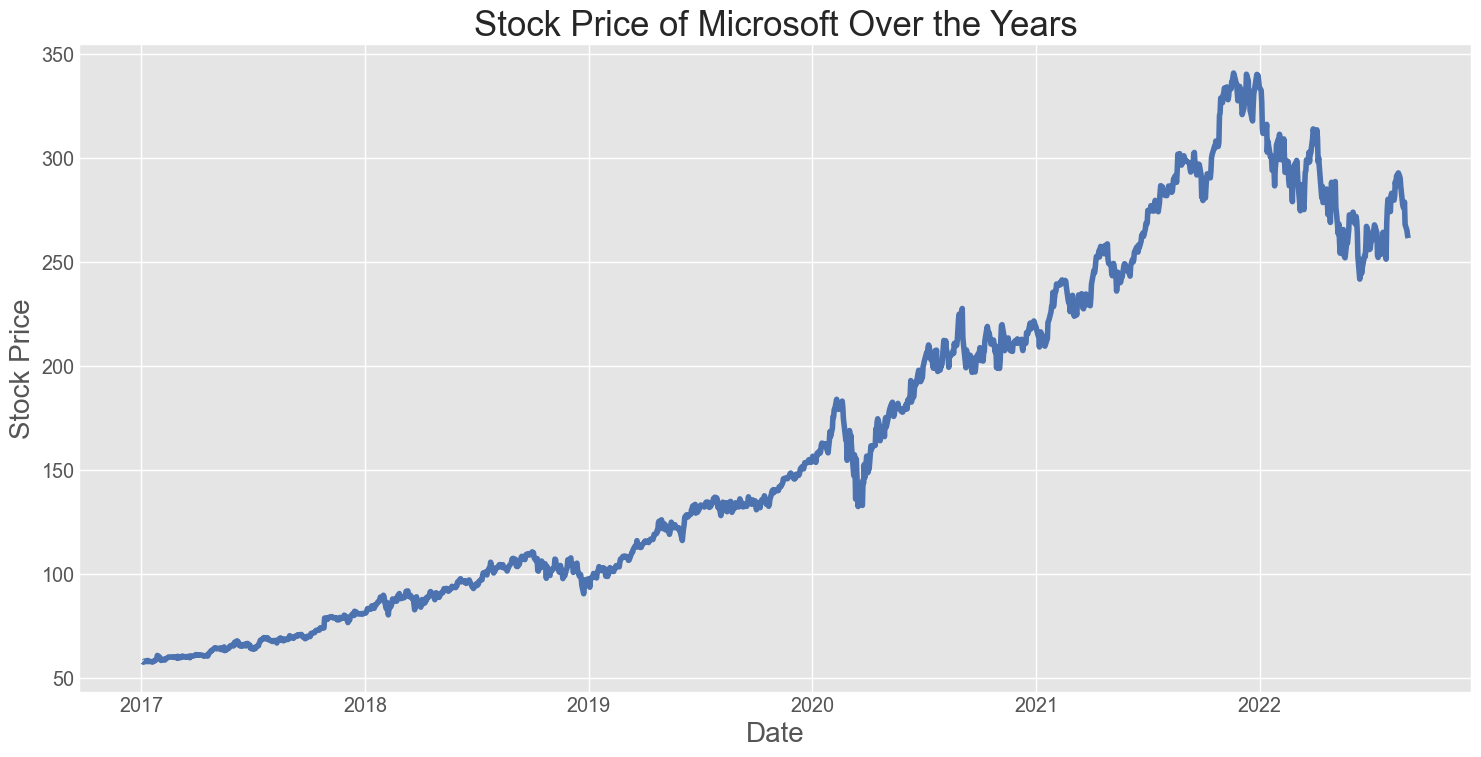

In [21]:
# plt.style.use('ggplot')
plt.figure(figsize=(16,8))
plt.plot(df['Adj_Close'], label='Close Price history',color='b')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Microsoft Over the Years',size=25);

We have data for ther year 2015 to 2021.

<a name="functions">

# <p style="background-color:#1c56c9; font-family:newtimeroman; font-size:150%; text-align:center; border-radius:  25px; color:#ffffff; padding-top:5px; padding-bottom:5px;">Functions</p>


In [6]:
# Normalizes the data
def to_dataset(data):
    data = data.astype('float32')
    #scaler = MinMaxScaler(feature_range=(0,1))
    #return scaler.fit_transform(data)
    return data/255.

# Data train and test
def train_test(data):
    train_size = int(len(data) * 0.75)
    train, test = data[0:train_size, :], data[train_size:len(data), :]
    return train, test

# Time windows - use 10 days to forecast the nest 10 days 
def windows(sequence, step_in, step_out):
    x, y = [], []
    for i in range(len(sequence)):
        end_i = i + step_in
        out_i = end_i + step_out
        if out_i > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_i, :], sequence[end_i:out_i, :]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Model
def creat_model(step_in, step_out, features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(step_in, features)))
    model.add(RepeatVector(step_out))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(features)))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Run all functions
def prepare_training(data, step_in, step_out):
    data = to_dataset(data)
    train, test = train_test(data)
    x_train, x_test = windows(train, step_in, step_out)
    y_train, y_test = windows(test, step_in, step_out)
    features = 1
    return x_train, x_test, y_train, y_test, features

<a name="model">

# <p style="background-color:#1c56c9; font-family:newtimeroman; font-size:150%; text-align:center; border-radius:  25px; color:#ffffff; padding-top:5px; padding-bottom:5px;">Model</p>

In [7]:
step_in, step_out = 10, 10 
epochs = 50 
batch_size = 32

early = EarlyStopping(monitor='val_loss',patience=5)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

In [8]:
data = df['Close'].values
data = data.reshape(-1, 1)

In [9]:
x_train, y_train, x_test, y_test, feature = prepare_training(data, step_in, step_out)

In [10]:
model = creat_model(step_in, step_out, feature)

In [11]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=144, verbose=1,
         validation_data=(x_test, y_test), callbacks=[early,reduce])

Epoch 1/50
8/8 [==============================] - 6s 213ms/step - loss: 0.2397 - mean_squared_error: 0.2397 - val_loss: 0.6650 - val_mean_squared_error: 0.6650 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 1s 78ms/step - loss: 0.0954 - mean_squared_error: 0.0954 - val_loss: 0.5352 - val_mean_squared_error: 0.5352 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 1s 102ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.2397 - val_mean_squared_error: 0.2397 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 0s 48ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - val_loss: 0.1828 - val_mean_squared_error: 0.1828 - lr: 0.0010
Epoch 5/50
8/8 [==============================] - 1s 86ms/step - loss: 0.0357 - mean_squared_error: 0.0357 - val_loss: 0.1357 - val_mean_squared_error: 0.1357 - lr: 0.0010
Epoch 6/50
8/8 [==============================] - 1s 93ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.0962 - val_mean_s

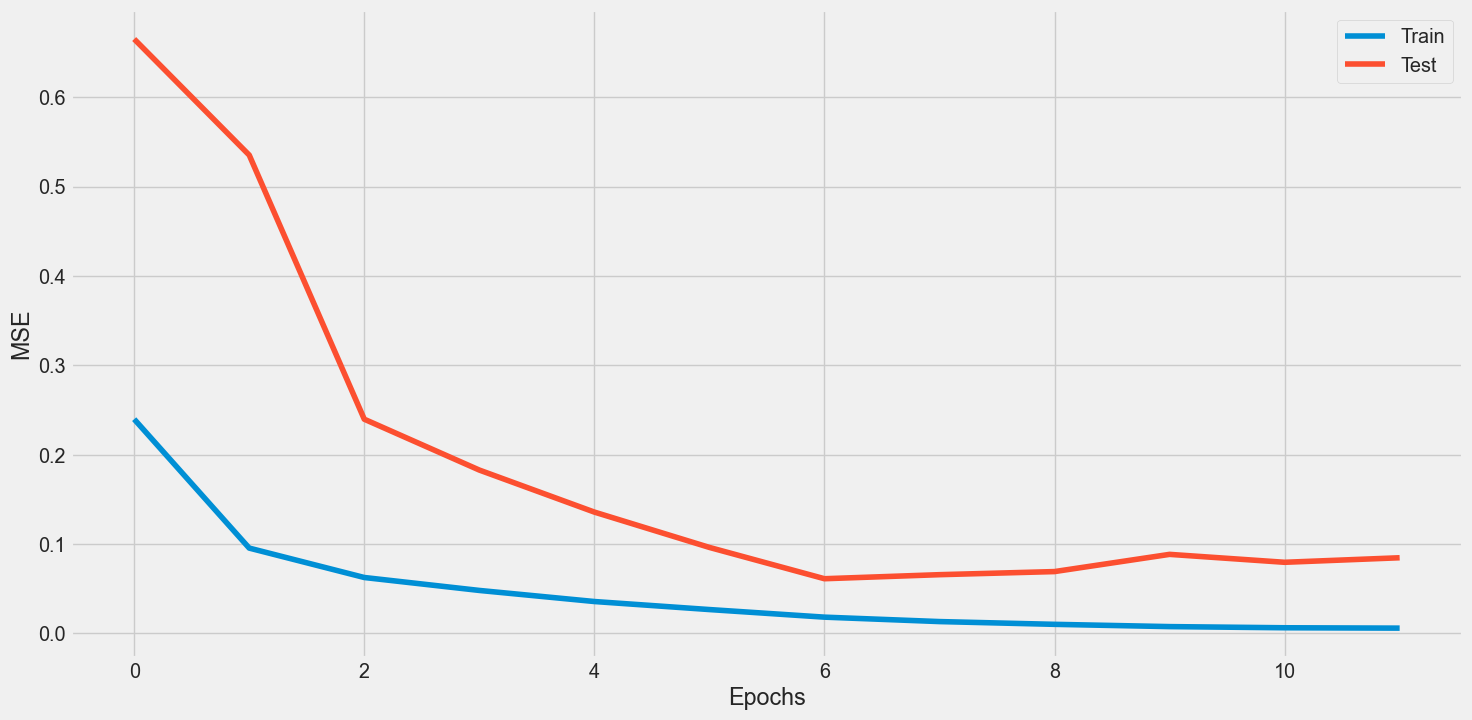

In [12]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Test']);

<a name="predictions">

# <p style="background-color:#1c56c9; font-family:newtimeroman; font-size:150%; text-align:center; border-radius:  25px; color:#ffffff; padding-top:5px; padding-bottom:5px;">Prediction</p>

In [14]:
pred = model.predict(x_test)

11/11 [==============================] - 0s 19ms/step


In [15]:
x = x_test[0]*255.0
y = pred[0]*255.0

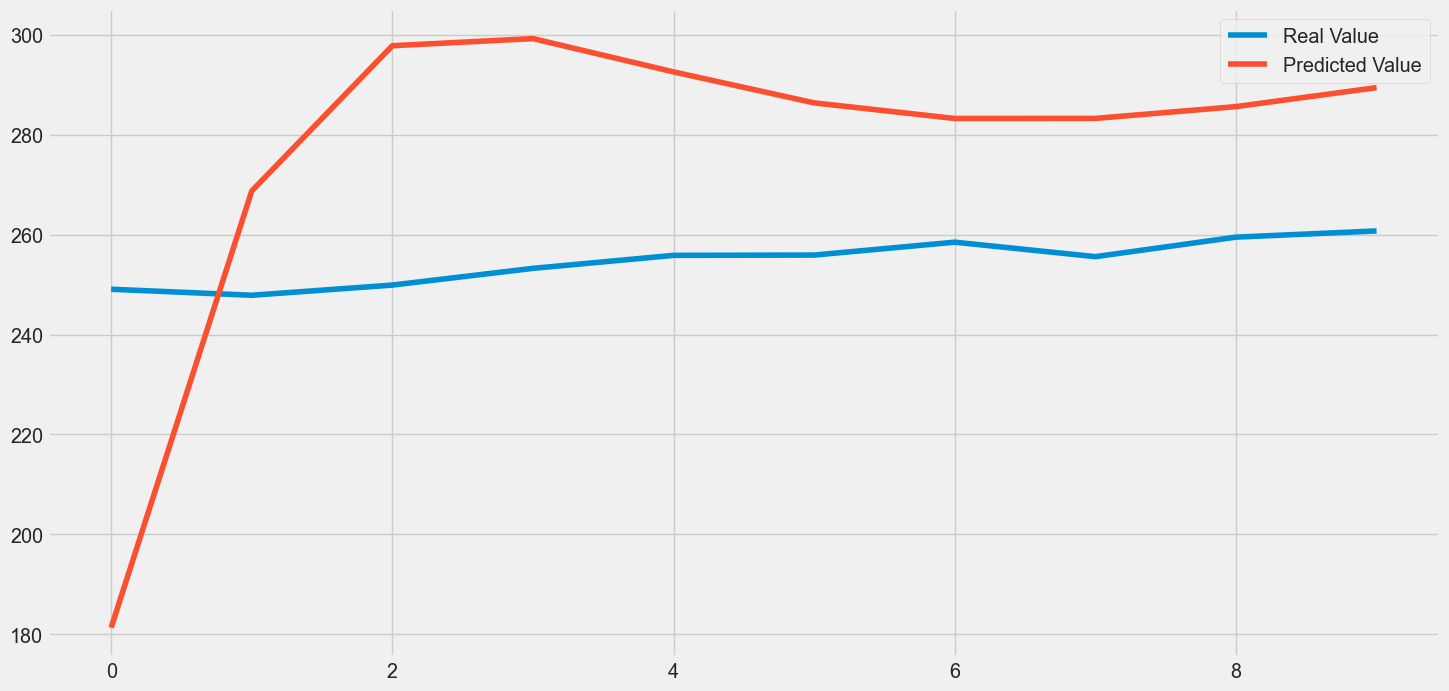

In [16]:
plt.plot(x)
plt.plot(y)
plt.legend(['Real Value','Predicted Value']);

<div style="color:black; background-color:#f5f7b0; font-size: 120%;border-radius:10px; padding:20px;">
<b>Conclusion</b><br/>
    
The model was not perfect but it got a result close to reality.
</div>